In [31]:
import os
import shutil
os.chdir('/content')
if os.path.isdir('./hetvae'):
  shutil.rmtree('./hetvae/')
! git clone --branch errors https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import optuna
from optuna.trial import TrialState
import torch.optim as optim
import models
from argparse import Namespace
import torch.optim as optim
import utils
import my_utils
import pandas as pd
import importlib
import vae_models
importlib.reload(vae_models)
importlib.reload(models)
importlib.reload(utils)
importlib.reload(my_utils)
from glob import glob
import matplotlib.pyplot as plt
import sys
del sys.modules['dataset']
from dataset import DataSet
%matplotlib inline

Cloning into 'hetvae'...
remote: Enumerating objects: 2028, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 2028 (delta 113), reused 89 (delta 51), pack-reused 1860
Receiving objects: 100% (2028/2028), 26.41 MiB | 25.27 MiB/s, done.
Resolving deltas: 100% (716/716), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Pick your poison:

In [24]:
#------------------------------
# AGN Preprocessing, we have a DF w/ OBJECT , FILTER, MJD, FLUX, ERROR
#------------------------------

def get_AGN_data(file):
    agn_df = pd.read_csv(file)
    # handle formatting for new AGN
    lcs = []
    for lc_df in agn_df.groupby('Filter'):
        lc = lc_df[1][['MJD', 'Flux', 'Error']].to_numpy()
        lcs.append(lc)

    AGN_1H2106 = DataSet()
    AGN_1H2106.dataset = lcs # skip add files part
    AGN_1H2106 = AGN_1H2106.handle_dups().prune_outliers().resample_dataset(num_samples=1).normalize().reorder() \
        .set_union_x().zero_fill().error_to_sample_weight().make_masks(frac=0.5)

    print(
        AGN_1H2106.union_x.shape,
        AGN_1H2106.dataset.shape,
        AGN_1H2106.subsampled_mask.shape,
        AGN_1H2106.recon_mask.shape
      )

    return AGN_1H2106

AGN_1H2106 = get_AGN_data('/content/hetvae/data/AGN_1H2106-099/1H2106-099_latest_lcs_pyroa.csv')

indexes of outliers to be pruned, if any: [600 601]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: [418 583]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: [ 98 205 260 261 554 555]
generating 1 new sample of each example in the dataset & appending them 
 old dataset length: 5
new dataset length: 10
created union_x attribute of length 2436
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (10, 619, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
(2436,) (10, 619, 3) (10, 619) (10, 619)


/content/hetvae/src/dataset.py:153: RuntimeWarning:

divide by zero encountered in true_divide




## Setting up arguments

In [84]:
def define_model_args(trial):

    args = Namespace(
        batch_size = trial.suggest_categorical("batch_size", [8,16,32]),
        bound_variance = True,
        const_var = False,
        dataset='toy',
        dropout = trial.suggest_float("dropout", 0.0,0.5),
        elbo_weight = trial.suggest_float("elbo_weight", 0.0, 5.0),
        embed_time = trial.suggest_categorical("embed_time", [8,16,32,64,128]),
        enc_num_heads=4,#trial.suggest_categorical("enc_num_heads", [1,2,4,8,16]),
        intensity=True,
        k_iwae=1,
        kl_annealing=False,#trial.suggest_categorical("kl_annealing",False),
        kl_zero=False, 
        latent_dim=trial.suggest_categorical("latent_dim", [8,16,32,64,128]),
        lr=trial.suggest_float("lr", 1e-7, 1e-1, log=True),
        mixing=trial.suggest_categorical("mixing", ["concat", "concat_and_mix"]),#"separate", "interp_only", "na"]),
        mse_weight=trial.suggest_float("mse_weight",1,10),
        n=trial.suggest_categorical("n", [8,16,32,64,128]),
        net='hetvae', 
        niters=1000, 
        norm=True, 
        normalize_input='znorm', 
        num_ref_points=trial.suggest_categorical("num_ref_points", [8,16,32,64,128]),
        rec_hidden=trial.suggest_categorical("rec_hidden", [8,16,32,64,128]),
        recon_loss=False, 
        sample_tp= trial.suggest_float("sample_tp", 0.1,0.9), # will be ignored
        save=True, 
        seed=0, 
        shuffle=True, 
        std=0.1, 
        var_per_dim=False, 
        width=trial.suggest_categorical("width", [8,16,32,64,128])
    )

    return args



In [85]:
FILES = glob('/content/hetvae/data/EDELSON/*')[:4]
Edelson = DataSet().add_files(FILES).files_to_numpy().handle_dups().prune_outliers().resample_dataset(num_samples=1) \
        .normalize().set_union_x().zero_fill().make_masks(frac=0.5)


        

dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 1 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 8
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (8, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes


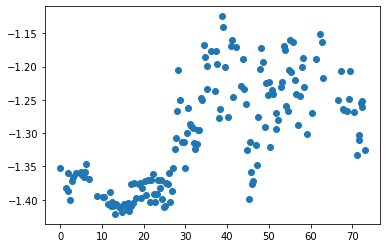

In [86]:
plt.scatter(Edelson.dataset[0,:-100,0], Edelson.dataset[0,:-100,1])

## **Generating Synthetic Data**

## **Loading HeTVAE model**

In [87]:
EPOCHS = 100
FILES = glob('/content/hetvae/data/EDELSON/*')[:4]
#FILES = glob('/content/hetvae/data/CAT/*/*')[:50]


DIM = 1
# definitly want a decaying error rate...
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1)


In [88]:
def objective(trial):

    args = define_model_args(trial)

    seed = args.seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # dataset hyperparams
    num_samples=trial.suggest_int("num_samples", 1,10)

    
    Edelson = DataSet().add_files(FILES).files_to_numpy().handle_dups().prune_outliers().resample_dataset(num_samples=num_samples) \
        .normalize().set_union_x().zero_fill().make_masks(frac=args.sample_tp)
    
    LightCurves = np.concatenate((Edelson.dataset, Edelson.subsampled_mask[:,:,np.newaxis], Edelson.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 

    training, valid = np.split(LightCurves, [int(np.floor(0.8*len(LightCurves)))])# shuffle?
    
    

    train_loader = torch.utils.data.DataLoader(training, batch_size=args.batch_size)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=args.batch_size)
    
    
    net = models.load_network(args, DIM, torch.Tensor(Edelson.union_x)) # , device="cuda"
    

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop", "SGD"])
    optimizer = getattr(optim, optimizer_name)(net.parameters(), lr=args.lr)

    for epoch in range(EPOCHS):
        train(net, optimizer, epoch, train_loader, args, device=device)
        nll_loss = my_utils.evaluate(net, valid_loader, device=device)
        trial.report(nll_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return nll_loss


In [89]:
study = optuna.create_study(direction="minimize")

[I 2022-06-09 00:18:53,928] A new study created in memory with name: no-name-d1610025-04a6-4bc3-bbb0-44ae30d36df4


In [93]:

study.optimize(objective, n_trials=50, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-06-09 00:21:29,869] Trial 30 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 10 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 44
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (44, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 14.8907, avg nll: 1.3926, avg kl: 0.1540, mse: 0.975249, mae: 0.908459
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDEL

[I 2022-06-09 00:21:30,022] Trial 31 pruned. 
[I 2022-06-09 00:21:30,113] Trial 32 pruned. 
[I 2022-06-09 00:21:30,195] Trial 33 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 9 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 40
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (40, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 12.2731, avg nll: 1.4366, avg kl: 0.4780, mse: 1.075681, mae: 0.923525
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELS

[I 2022-06-09 00:21:30,283] Trial 34 pruned. 


Iter: 0, train loss: 10.1666, avg nll: 1.4328, avg kl: 0.6285, mse: 0.925007, mae: 0.860482
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 8 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 36
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (36, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 7.7632, avg nll: 1.1303, avg kl: 0.6260, mse: 0.566473, mae: 0.628218


[I 2022-06-09 00:21:37,030] Trial 35 finished with value: -0.2572128176689148 and parameters: {'batch_size': 8, 'dropout': 0.4810761392356336, 'elbo_weight': 2.071299946284342, 'embed_time': 128, 'latent_dim': 128, 'lr': 8.709877385989801e-05, 'mixing': 'concat_and_mix', 'mse_weight': 7.282360531230097, 'n': 32, 'num_ref_points': 8, 'rec_hidden': 128, 'sample_tp': 0.6765744000890945, 'width': 32, 'num_samples': 8, 'optimizer': 'RMSprop'}. Best is trial 27 with value: -1.3348125219345093.
[I 2022-06-09 00:21:37,222] Trial 36 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 8 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 36
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (36, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 13.7481, avg nll: 1.4478, avg kl: 1.8606, mse: 0.992280, mae: 0.912265
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELS

[I 2022-06-09 00:21:37,342] Trial 37 pruned. 
[I 2022-06-09 00:21:37,450] Trial 38 pruned. 


generating 6 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 28
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (28, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 13.8891, avg nll: 1.4187, avg kl: 1.0458, mse: 0.982313, mae: 0.879263
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 7 new sample of each example in the dataset & appending them 
 old dataset length: 4


[I 2022-06-09 00:21:37,562] Trial 39 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 10 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 44
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (44, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 11.7295, avg nll: 1.6966, avg kl: 0.3042, mse: 0.888040, mae: 0.862328
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDEL

[I 2022-06-09 00:22:01,857] Trial 40 finished with value: -0.7755855321884155 and parameters: {'batch_size': 8, 'dropout': 0.4054366035536934, 'elbo_weight': 2.507255513253629, 'embed_time': 64, 'latent_dim': 128, 'lr': 0.00313242421682065, 'mixing': 'concat_and_mix', 'mse_weight': 7.392052838060305, 'n': 32, 'num_ref_points': 64, 'rec_hidden': 128, 'sample_tp': 0.7592930699731995, 'width': 128, 'num_samples': 8, 'optimizer': 'Adam'}. Best is trial 27 with value: -1.3348125219345093.


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 8 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 36
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (36, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 14.1685, avg nll: 0.9988, avg kl: 3.4959, mse: 0.383519, mae: 0.486055


[I 2022-06-09 00:22:26,155] Trial 41 finished with value: -0.8782585263252258 and parameters: {'batch_size': 8, 'dropout': 0.47183170841952965, 'elbo_weight': 2.5133413168547403, 'embed_time': 64, 'latent_dim': 128, 'lr': 0.0028855977258093793, 'mixing': 'concat_and_mix', 'mse_weight': 7.4884787182582695, 'n': 32, 'num_ref_points': 64, 'rec_hidden': 128, 'sample_tp': 0.7566491850790921, 'width': 128, 'num_samples': 8, 'optimizer': 'Adam'}. Best is trial 27 with value: -1.3348125219345093.


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 7 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 32
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (32, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes


[I 2022-06-09 00:22:26,426] Trial 42 pruned. 


Iter: 0, train loss: 36.9138, avg nll: 2.1384, avg kl: 3.8630, mse: 2.908208, mae: 1.533621
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 8 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 36
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (36, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 17.6242, avg nll: 0.9980, avg kl: 7.5768, mse: 0.395383, mae: 0.492445


[I 2022-06-09 00:22:50,722] Trial 43 finished with value: -0.6959786415100098 and parameters: {'batch_size': 8, 'dropout': 0.4148246860905467, 'elbo_weight': 1.8007186213269828, 'embed_time': 64, 'latent_dim': 128, 'lr': 0.0012628905886337613, 'mixing': 'concat_and_mix', 'mse_weight': 5.522034096716964, 'n': 32, 'num_ref_points': 64, 'rec_hidden': 128, 'sample_tp': 0.8475874005891189, 'width': 128, 'num_samples': 8, 'optimizer': 'Adam'}. Best is trial 27 with value: -1.3348125219345093.


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 9 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 40
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (40, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 20.7652, avg nll: 0.9719, avg kl: 6.9289, mse: 0.362781, mae: 0.467541


[I 2022-06-09 00:23:17,644] Trial 44 finished with value: -0.5313577651977539 and parameters: {'batch_size': 8, 'dropout': 0.4251757571442667, 'elbo_weight': 2.3729230090489297, 'embed_time': 64, 'latent_dim': 128, 'lr': 0.001145621166958565, 'mixing': 'concat_and_mix', 'mse_weight': 5.560444818538853, 'n': 32, 'num_ref_points': 64, 'rec_hidden': 128, 'sample_tp': 0.8391023445958533, 'width': 128, 'num_samples': 9, 'optimizer': 'Adam'}. Best is trial 27 with value: -1.3348125219345093.


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 10 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 44
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (44, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 11.4944, avg nll: 0.9438, avg kl: 4.2800, mse: 0.403766, mae: 0.504960


[I 2022-06-09 00:23:23,449] Trial 45 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 9 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 40
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (40, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 8.2757, avg nll: 0.9843, avg kl: 3.5618, mse: 0.369416, mae: 0.470111


[I 2022-06-09 00:23:50,384] Trial 46 finished with value: -0.7177515625953674 and parameters: {'batch_size': 8, 'dropout': 0.4250289661915361, 'elbo_weight': 1.371870387283783, 'embed_time': 64, 'latent_dim': 128, 'lr': 0.002470808266358915, 'mixing': 'concat_and_mix', 'mse_weight': 5.519665781518734, 'n': 32, 'num_ref_points': 64, 'rec_hidden': 128, 'sample_tp': 0.7681901354243718, 'width': 128, 'num_samples': 9, 'optimizer': 'Adam'}. Best is trial 27 with value: -1.3348125219345093.


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 9 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 40
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (40, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes


[I 2022-06-09 00:23:50,709] Trial 47 pruned. 


Iter: 0, train loss: 72.3550, avg nll: 7.2557, avg kl: 6.6500, mse: 11.028199, mae: 2.151699
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 8 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 36
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (36, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 8.0194, avg nll: 1.0293, avg kl: 3.4781, mse: 0.412421, mae: 0.502859


[I 2022-06-09 00:24:15,036] Trial 48 finished with value: -0.38215866684913635 and parameters: {'batch_size': 8, 'dropout': 0.4528227066330205, 'elbo_weight': 1.210367314231421, 'embed_time': 64, 'latent_dim': 128, 'lr': 0.0031372951681042705, 'mixing': 'concat_and_mix', 'mse_weight': 6.216738478958387, 'n': 32, 'num_ref_points': 64, 'rec_hidden': 128, 'sample_tp': 0.7623987767457493, 'width': 128, 'num_samples': 8, 'optimizer': 'Adam'}. Best is trial 27 with value: -1.3348125219345093.


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 10 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 44
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (44, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes


/usr/local/lib/python3.7/dist-packages/optuna/pruners/_percentile.py:21: RuntimeWarning:

All-NaN slice encountered

[I 2022-06-09 00:24:15,397] Trial 49 pruned. 


Iter: 0, train loss: nan, avg nll: nan, avg kl: nan, mse: nan, mae: nan
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 6 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 28
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (28, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes


[I 2022-06-09 00:24:15,638] Trial 50 pruned. 


Iter: 0, train loss: 30.5679, avg nll: 1.4787, avg kl: 9.4095, mse: 0.894329, mae: 0.842119
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 9 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 40
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (40, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 17.4960, avg nll: 0.9578, avg kl: 5.7089, mse: 0.349939, mae: 0.457678


[I 2022-06-09 00:24:42,557] Trial 51 finished with value: -0.6741089224815369 and parameters: {'batch_size': 8, 'dropout': 0.42218850724991785, 'elbo_weight': 2.327156732324386, 'embed_time': 64, 'latent_dim': 128, 'lr': 0.0020541986055275293, 'mixing': 'concat_and_mix', 'mse_weight': 5.662393617858744, 'n': 32, 'num_ref_points': 64, 'rec_hidden': 128, 'sample_tp': 0.8456007743854639, 'width': 128, 'num_samples': 9, 'optimizer': 'Adam'}. Best is trial 27 with value: -1.3348125219345093.


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 9 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 40
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (40, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes


[I 2022-06-09 00:24:42,886] Trial 52 pruned. 


Iter: 0, train loss: 44.2381, avg nll: 2.2244, avg kl: 5.9680, mse: 4.209464, mae: 1.620304
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 8 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 36
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (36, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 10.0625, avg nll: 1.0193, avg kl: 5.1685, mse: 0.404518, mae: 0.499993


[I 2022-06-09 00:25:07,211] Trial 53 finished with value: -0.09317673742771149 and parameters: {'batch_size': 8, 'dropout': 0.41880248893531125, 'elbo_weight': 1.2491900354301773, 'embed_time': 64, 'latent_dim': 128, 'lr': 0.002283207523068211, 'mixing': 'concat_and_mix', 'mse_weight': 5.766578465419184, 'n': 32, 'num_ref_points': 64, 'rec_hidden': 128, 'sample_tp': 0.8198841391472826, 'width': 128, 'num_samples': 8, 'optimizer': 'Adam'}. Best is trial 27 with value: -1.3348125219345093.


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 10 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 44
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (44, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes


[I 2022-06-09 00:25:07,569] Trial 54 pruned. 


Iter: 0, train loss: 11.0283, avg nll: 1.4673, avg kl: 2.4283, mse: 0.703717, mae: 0.674099
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 9 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 40
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (40, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 6.5167, avg nll: 1.0338, avg kl: 0.1905, mse: 0.470950, mae: 0.558049


[I 2022-06-09 00:25:13,573] Trial 55 finished with value: -1.0225275754928589 and parameters: {'batch_size': 8, 'dropout': 0.3628041115152569, 'elbo_weight': 2.689544797292487, 'embed_time': 64, 'latent_dim': 8, 'lr': 0.0040981930895590485, 'mixing': 'concat_and_mix', 'mse_weight': 6.845656443359978, 'n': 64, 'num_ref_points': 64, 'rec_hidden': 128, 'sample_tp': 0.7544617821694009, 'width': 128, 'num_samples': 9, 'optimizer': 'Adam'}. Best is trial 27 with value: -1.3348125219345093.
[I 2022-06-09 00:25:13,663] Trial 56 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 8 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 36
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (36, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 11.9533, avg nll: 1.4129, avg kl: 0.6983, mse: 0.953896, mae: 0.854193
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELS

[I 2022-06-09 00:25:19,708] Trial 57 finished with value: -1.3141472339630127 and parameters: {'batch_size': 8, 'dropout': 0.34153324454766504, 'elbo_weight': 1.0213955154796894, 'embed_time': 64, 'latent_dim': 8, 'lr': 0.0037581076281177875, 'mixing': 'concat_and_mix', 'mse_weight': 6.94093447554597, 'n': 64, 'num_ref_points': 64, 'rec_hidden': 128, 'sample_tp': 0.7452956304501247, 'width': 128, 'num_samples': 9, 'optimizer': 'Adam'}. Best is trial 27 with value: -1.3348125219345093.


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 10 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 44
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (44, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 3.7952, avg nll: 1.0202, avg kl: 0.2584, mse: 0.469765, mae: 0.561472


[I 2022-06-09 00:25:27,244] Trial 58 finished with value: -0.9930165410041809 and parameters: {'batch_size': 8, 'dropout': 0.29101522853721185, 'elbo_weight': 0.4420480441006349, 'embed_time': 64, 'latent_dim': 8, 'lr': 0.003225184504003554, 'mixing': 'concat_and_mix', 'mse_weight': 6.875830791230692, 'n': 64, 'num_ref_points': 64, 'rec_hidden': 128, 'sample_tp': 0.6109699127129304, 'width': 128, 'num_samples': 10, 'optimizer': 'Adam'}. Best is trial 27 with value: -1.3348125219345093.
[I 2022-06-09 00:25:27,331] Trial 59 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 10 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 44
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (44, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 7.6879, avg nll: 1.4591, avg kl: 0.0754, mse: 0.991438, mae: 0.913021
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELS

[I 2022-06-09 00:25:27,670] Trial 60 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 9 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 40
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (40, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 3.4085, avg nll: 1.0426, avg kl: 0.4874, mse: 0.502605, mae: 0.581495


[I 2022-06-09 00:25:33,669] Trial 61 finished with value: -1.2887210845947266 and parameters: {'batch_size': 8, 'dropout': 0.3559252851202308, 'elbo_weight': 0.03816311883675172, 'embed_time': 64, 'latent_dim': 8, 'lr': 0.003139145380339434, 'mixing': 'concat_and_mix', 'mse_weight': 6.665459940569918, 'n': 64, 'num_ref_points': 64, 'rec_hidden': 128, 'sample_tp': 0.7404504050482054, 'width': 128, 'num_samples': 9, 'optimizer': 'Adam'}. Best is trial 27 with value: -1.3348125219345093.
[I 2022-06-09 00:25:33,780] Trial 62 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 9 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 40
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (40, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 3.3193, avg nll: 1.0224, avg kl: 0.4890, mse: 0.468718, mae: 0.559207
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSO

[I 2022-06-09 00:25:33,907] Trial 63 pruned. 
[I 2022-06-09 00:25:34,037] Trial 64 pruned. 
[I 2022-06-09 00:25:34,136] Trial 65 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 9 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 40
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (40, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 7.4928, avg nll: 1.4427, avg kl: 1.0579, mse: 0.948406, mae: 0.868960
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSO

[I 2022-06-09 00:25:34,264] Trial 66 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 10 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 44
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (44, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 4.5699, avg nll: 1.1947, avg kl: 0.4031, mse: 0.655755, mae: 0.710328
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELS

[I 2022-06-09 00:25:34,375] Trial 67 pruned. 
[I 2022-06-09 00:25:34,469] Trial 68 pruned. 
[I 2022-06-09 00:25:34,583] Trial 69 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 9 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 40
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (40, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 13.5034, avg nll: 1.4381, avg kl: 0.5786, mse: 0.935934, mae: 0.887472
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELS

[I 2022-06-09 00:25:34,740] Trial 70 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 8 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 36
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (36, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 9.0898, avg nll: 1.4462, avg kl: 0.8854, mse: 0.979767, mae: 0.881060
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSO

[I 2022-06-09 00:25:40,742] Trial 71 finished with value: -1.4427396059036255 and parameters: {'batch_size': 8, 'dropout': 0.3193066765937042, 'elbo_weight': 1.0592197576398512, 'embed_time': 64, 'latent_dim': 8, 'lr': 0.002237181871271614, 'mixing': 'concat_and_mix', 'mse_weight': 7.71433749185757, 'n': 64, 'num_ref_points': 64, 'rec_hidden': 128, 'sample_tp': 0.748037013565007, 'width': 128, 'num_samples': 9, 'optimizer': 'Adam'}. Best is trial 71 with value: -1.4427396059036255.
[I 2022-06-09 00:25:40,860] Trial 72 pruned. 
[I 2022-06-09 00:25:40,970] Trial 73 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 9 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 40
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (40, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 5.4657, avg nll: 1.1961, avg kl: 0.3208, mse: 0.696702, mae: 0.742053
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSO

[I 2022-06-09 00:25:45,497] Trial 74 finished with value: -1.1747866868972778 and parameters: {'batch_size': 8, 'dropout': 0.26658515881302086, 'elbo_weight': 1.052594696190622, 'embed_time': 64, 'latent_dim': 8, 'lr': 0.0046185085039948314, 'mixing': 'concat_and_mix', 'mse_weight': 8.689945005013206, 'n': 64, 'num_ref_points': 16, 'rec_hidden': 128, 'sample_tp': 0.8178002069997888, 'width': 128, 'num_samples': 8, 'optimizer': 'Adam'}. Best is trial 71 with value: -1.4427396059036255.
[I 2022-06-09 00:25:45,560] Trial 75 pruned. 
[I 2022-06-09 00:25:45,643] Trial 76 pruned. 
[I 2022-06-09 00:25:45,718] Trial 77 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 1 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 8
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (8, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 12.5650, avg nll: 1.5765, avg kl: 0.3123, mse: 1.152128, mae: 0.952259
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON

[I 2022-06-09 00:25:45,819] Trial 78 pruned. 
[I 2022-06-09 00:25:45,901] Trial 79 pruned. 


dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
indexes of outliers to be pruned, if any: [ 87  96 102]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
generating 7 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 32
created union_x attribute of length 916
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (32, 264, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
Iter: 0, train loss: 5.7888, avg nll: 1.1544, avg kl: 0.1360, mse: 0.584110, mae: 0.644506
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSO

## **Training**

In [9]:
def train(net, optimizer,epoch, train_loader, args, device="cuda"):
      
      train_loss = 0.
      train_n = 0.
      avg_loglik, avg_kl, mse, mae = 0., 0., 0., 0.
      for i, train_batch in enumerate(train_loader):
          batch_len = train_batch.shape[0] 
          train_batch = train_batch.to(device)
          x = train_batch[:,:,0]
          y = train_batch[:,:,1:2]
          
          subsampled_mask = train_batch[:,:,3:4]
          recon_mask = train_batch[:,:,4:]
          sample_weight = train_batch[:,:,2:3]
          seqlen = train_batch.size(1) 
          # subsampled flux values and their corresponding masks....
          context_y = torch.cat((
              y * subsampled_mask, subsampled_mask
          ), -1) 
          recon_context_y = torch.cat((            # flux values with only recon_mask values showing
                  y * recon_mask, recon_mask
              ), -1)
          
    # #   def compute_unsupervised_loss(self, context_x, context_y, target_x, target_y, num_samples=1, beta=1):
          loss_info = net.compute_unsupervised_loss(
              x, # context_x, times
              context_y,             # context_y
              x, # target_x, same times? 
              recon_context_y,
              num_samples=args.k_iwae, # 1? 
              beta=1,
              # optional, will be zero if not set
              #sample_weight = sample_weight   # default is 1. (no errors provided)

          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          #scheduler.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len
      
      
      if epoch % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  epoch,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )
      
        


In [ ]:
for g in optimizer.param_groups:
    print(g['lr'])
    g['lr'] = 0.001

0.0009


In [13]:
my_utils.viz_per_example(Edelson.dataset[1], net, device=device, k_iwae=10, n_max=10, fracs=[0.05,0.1,0.15])

NameError: ignored

In [14]:
optuna.visualization.plot_param_importances(study)

In [15]:
optuna.visualization.plot_optimization_history(study)

In [17]:
optuna.visualization.plot_slice(study, params=["optimizer"])